# Library

In [64]:
import pandas as pd
import numpy as np
import os
import re
import collections
#from gensim.parsing.preprocessing import remove_stopwords
import nltk
from nltk.corpus import stopwords
import itertools 
from nltk.tokenize import word_tokenize
from nltk.tag.stanford import StanfordPOSTagger
from string import punctuation
from textblob import TextBlob

from string import punctuation

from nltk import ngrams

import matplotlib as plt
import seaborn as sns

import shap

from pycaret.classification import *

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Functions

In [6]:
#java path for standford tagger
java_path = "C:\Program Files (x86)\Java\jre1.8.0_201"
os.environ['JAVAHOME'] = java_path

In [7]:
# Load Standford Spanish POS tagger
_model_filename = r'C:/Users/cx02274/Documents/master/stanford-postagger/models/spanish-ud.tagger'
_path_to_jar = r'C:/Users/cx02274/Documents/master/stanford-postagger/stanford-postagger-4.1.0.jar'
st = StanfordPOSTagger(model_filename=_model_filename, path_to_jar=_path_to_jar,encoding='utf8')

In [2]:
def read_texts(path):
    data = []
    file_name = os.listdir(path)

    for name in file_name:
        if name.endswith('.txt'):
            with open(path + name,encoding="utf8") as f:
                text = f.read()
                data.append({'nombre':name.replace('.txt',''), 'texto':text})

    df = pd.DataFrame(data)
    return df

In [3]:
def isVowel(x):
    return x.lower() in 'aeiou'

def isConsonant(x):
    if x.isalpha():
        return x.lower() not in 'aeiou'

# Load Data

### Trainning

318 clinical cases

In [9]:
train_abbr = pd.read_csv("../datasets/trainning_set/clinical_cases.abbreviations.training_set.tsv", sep = '\t')
train_met = pd.read_csv("../datasets/trainning_set/clinical_cases.metadata.training_set.tsv", sep = '\t')
train_rel = pd.read_csv("../datasets/trainning_set/clinical_cases.relations.training_set.tsv", sep = '\t')

In [10]:
train_abbr.head()

,# Document_ID,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
0,S0210-48062004000500008-1,1650,1652,ml,mililitro,mililitro
1,S0210-48062004000500008-1,708,709,l,litro,litro
2,S0210-48062004000500008-1,704,707,mEq,miliequivalente,miliequivalente
3,S0210-48062004000500008-1,677,681,pCO2,presión parcial de co2,presión parcial de co2
4,S0210-48062004000500008-1,2287,2290,HLA,human leucocyte antigen,human leucocyte antiger


In [11]:
train_met = train_met.rename(columns = {'# Document_ID': 'doc_id'})

In [12]:
train_met.head()

,doc_id,Case_ID,ISSN,Date,Source,Full_Text_Link
0,S1139-76322015000500009-1.txt,1.txt,1139-7632,2015-12-01,Pediatría Atención Primaria v.17 n.68 2015,http://scielo.isciii.es/scielo.php?script=sci_...
1,S1130-05582008000400007-2.txt,2.txt,1130-0558,2008-08-01,Revista Española de Cirugía Oral y Maxilofacia...,http://scielo.isciii.es/scielo.php?script=sci_...
2,S0210-48062006000100012-1.txt,1.txt,0210-4806,2006-01-01,Actas Urológicas Españolas v.30 n.1 2006,http://scielo.isciii.es/scielo.php?script=sci_...
3,S0213-12852003000500002-1.txt,1.txt,0213-1285,2003-10-01,Avances en Odontoestomatología v.19 n.5 2003,http://scielo.isciii.es/scielo.php?script=sci_...
4,S0212-71992005000400007-1.txt,1.txt,0212-7199,2005-04-01,Anales de Medicina Interna v.22 n.4 2005,http://scielo.isciii.es/scielo.php?script=sci_...


In [13]:
train_rel = train_rel.reset_index()

In [14]:
train_rel.columns = ['# Document_ID', 'Mention_A_type', 'Mention_A_StartOffset',
      'Mention_A', 'Relation_type', 'Mention_B_type',
       'Mention_B_StartOffset', 'Mention_B_EndOffset', 'Mention_B']

In [15]:
train_rel = train_rel.rename(columns = {'# Document_ID': 'doc_id'})

In [16]:
train_rel.head()

,doc_id,Mention_A_type,Mention_A_StartOffset,Mention_A,Relation_type,Mention_B_type,Mention_B_StartOffset,Mention_B_EndOffset,Mention_B
0,S1130-01082009000400014-1,SHORT_FORM,476,NPT,SHORT-LONG,LONG_FORM,454.0,474.0,nutrición parenteral
1,S1130-63432016000100009-1,SHORT_FORM,614,NIHSS,SHORT-LONG,LONG_FORM,621.0,662.0,National Institute of Health Stroke Scale
2,S1139-76322017000200007-1,SHORT_FORM,1145,CMV,SHORT-LONG,LONG_FORM,1128.0,1143.0,citomegalovirus
3,S1139-76322017000200007-1,SHORT_FORM,1243,VSG,SHORT-LONG,LONG_FORM,1206.0,1241.0,velocidad de sedimentación globular
4,S1139-76322017000200007-1,SHORT_FORM,1300,IGRA,SHORT-LONG,LONG_FORM,1267.0,1298.0,interferon-gamma release assays


In [17]:
train_abbr = train_abbr.rename(columns = {'# Document_ID': 'doc_id'})

In [18]:
train_raw = read_texts("../datasets/trainning_set/training_set.raw_text/txt/")

In [19]:
train_raw = train_raw.rename(columns = {'nombre': 'doc_id'})

In [20]:
train_raw.head()

,doc_id,texto
0,S0004-06142005000900013-1,Se trata de una mujer de 29 años sometida a un...
1,S0004-06142005000900015-1,"Varón de 36 años, sin antecedentes de interés,..."
2,S0004-06142005000900016-1,Mujer de 29 años con antecedentes de ulcus duo...
3,S0004-06142005001000011-1,Varón de 58 años de edad en el momento del tra...
4,S0004-06142005001000011-3,Mujer de 42 años en el momento de someterse a ...


# Sub-track 1

## Found abbreviations (Short Forms)

### Supervised model

#### Create input dataframe

In [21]:
#tokenize text
train_raw['tokens'] = train_raw['texto'].map(lambda x: word_tokenize(x, language = 'spanish'))

In [22]:
# # print(train_raw.iloc[30]['texto'])
# for i in range(0,11):
#     print(train_raw.iloc[i]['tokens'])

In [23]:
#nltk.download('stopwords')
swords = list(set(stopwords.words('spanish')))
punctuation = [p for p in punctuation]

In [24]:
# Remove single punctuation from tokens and stop words in tokens
train_raw['tokens'] = train_raw['tokens'].map(lambda x: [a for a in x if a not in punctuation])
train_raw['tokens'] = train_raw['tokens'].map(lambda x: [w for w in x if w not in swords])

In [25]:
abrev = train_abbr['Abbreviation'].unique().tolist()

In [26]:
train_tokens = train_raw[['tokens']].explode('tokens')

In [27]:
train_tokens.head()

,tokens
0,Se
0,trata
0,mujer
0,29
0,años


In [28]:
train_tokens['acronym'] = train_tokens['tokens'].map(lambda x: 1 if x in abrev else 0)

In [29]:
train_tokens = train_tokens.drop_duplicates()

In [30]:
train_tokens.shape

(14235, 2)

In [31]:
train_tokens[train_tokens['acronym'] == 1].head()

,tokens,acronym
0,mm,1
0,HHF35,1
0,A,1
1,CT,1
1,MESNA,1


Create derivated features

In [60]:
train_tokens['len'] = train_tokens['tokens'].map(lambda x: len(x)) #word len
train_tokens['numbers'] = train_tokens['tokens'].map(lambda x: sum(y.isdigit() for y in x)/len(x)) #density of digits in the word
train_tokens['num_upper'] = train_tokens['tokens'].map(lambda x: sum(y.isupper() for y in x)/len(x)) #density of mayus
train_tokens['num_lower'] = train_tokens['tokens'].map(lambda x: sum(y.islower() for y in x)/len(x)) #density of lowers
train_tokens['num_vowels'] = train_tokens['tokens'].map(lambda x: sum([isVowel(i) for i in x])/len(x)) #density of vowels
train_tokens['num_consonants'] = train_tokens['tokens'].map(lambda x: [isConsonant(i) for i in x].count(True)/len(x)) #density of consonants
train_tokens['num_alpha'] = train_tokens['tokens'].map(lambda x: sum(y.isalpha() for y in x)/len(x)) #density alphanumeric values
train_tokens['num_spaces'] = train_tokens['tokens'].map(lambda x: sum(y.isspace() for y in x)) #number of spaces
train_tokens['num_slide'] = train_tokens['tokens'].map(lambda x: len([y for y in x if y=='/'])) #number of slide bars
train_tokens['num_hyphen'] = train_tokens['tokens'].map(lambda x: len([y for y in x if y=='-'])) #number of hypens
train_tokens['num_dot'] = train_tokens['tokens'].map(lambda x: len([y for y in x if y=='.'])) #number of dots

In [66]:
train_tokens['texto_POS'] = train_tokens['tokens'].map(lambda x: st.tag(nltk.word_tokenize(x)))

In [73]:
train_tokens['POS_PROPN'] = train_tokens['texto_POS'].map(lambda x: 1 if x[0][1] == 'PROPN' else 0)
del train_tokens['texto_POS'] 

In [4]:
train_tokens = pd.read_csv("../datasets/acron_ml.csv")

In [7]:
train_tokens.columns

Index(['Unnamed: 0', 'tokens', 'acronym', 'numbers', 'num_alpha', 'num_upper',
       'num_spaces', 'len', 'num_lower', 'num_vowels', 'num_consonants',
       'num_slide', 'num_hyphen', 'num_dot', 'texto_POS'],
      dtype='object')

In [8]:
del train_tokens['Unnamed: 0']

In [11]:
train_tokens['POS_PROPN'] = train_tokens['texto_POS'].map(lambda x: 1 if x[1] == 'PROPN' else 0)
del train_tokens['texto_POS'] 

In [12]:
train_tokens.head()

,tokens,acronym,numbers,num_alpha,num_upper,num_spaces,len,num_lower,num_vowels,num_consonants,num_slide,num_hyphen,num_dot,POS_PROPN
0,Se,0,0.0,1.0,0.5,0,2,0.5,0.5,0.5,0,0,0,0
1,trata,0,0.0,1.0,0.0,0,5,1.0,0.4,0.6,0,0,0,0
2,mujer,0,0.0,1.0,0.0,0,5,1.0,0.4,0.6,0,0,0,0
3,29,0,1.0,0.0,0.0,0,2,0.0,0.0,0.0,0,0,0,0
4,años,0,0.0,1.0,0.0,0,4,1.0,0.5,0.5,0,0,0,0


In [14]:
train_tokens = train_tokens[['acronym', 'numbers', 'num_alpha', 'num_upper', 'num_spaces',
       'len', 'num_lower', 'num_vowels', 'num_consonants', 'num_slide',
       'num_hyphen', 'num_dot', 'POS_PROPN']]

In [43]:
correlation_matrix = train_tokens.corr()

Text(0.5, 1.0, 'Triangle Correlation Heatmap')

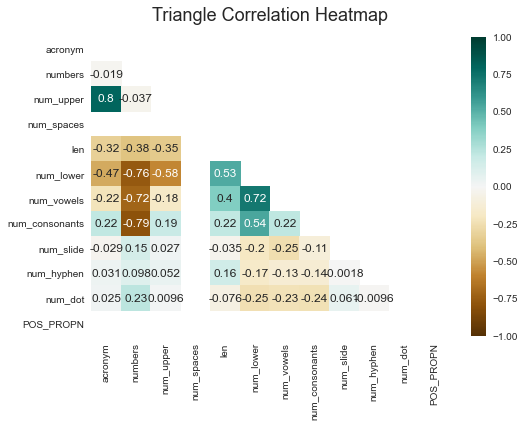

In [44]:
# plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))
heatmap = sns.heatmap(correlation_matrix, mask = mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16)

In [42]:
train_tokens = train_tokens[['acronym', 'numbers', 'num_upper', 'num_spaces',
       'len', 'num_lower', 'num_vowels', 'num_consonants', 'num_slide',
       'num_hyphen', 'num_dot', 'POS_PROPN']]

### Model

In [46]:
exp_clf101 = setup(data = train_tokens, target = 'acronym', session_id=123)

Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(14235, 12)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [47]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extreme Gradient Boosting,0.9872,0.9950,0.8583,0.8592,0.8582,0.8515,0.8518,0.5602
1,CatBoost Classifier,0.9869,0.9959,0.8628,0.8511,0.8562,0.8493,0.8497,7.8621
2,Gradient Boosting Classifier,0.9866,0.9960,0.8495,0.8552,0.8515,0.8444,0.8449,0.6117
3,Light Gradient Boosting Machine,0.9865,0.9953,0.8517,0.8518,0.8508,0.8437,0.8442,0.2287
4,K Neighbors Classifier,0.9864,0.9698,0.8428,0.8573,0.8488,0.8416,0.8423,0.0813
5,Random Forest Classifier,0.9857,0.9852,0.8452,0.8439,0.8435,0.8360,0.8366,0.1501
6,Extra Trees Classifier,0.9855,0.9792,0.8297,0.8502,0.8389,0.8313,0.8319,0.4015
7,Decision Tree Classifier,0.9852,0.9606,0.8318,0.8438,0.8364,0.8287,0.8294,0.0176
8,Logistic Regression,0.9831,0.9950,0.7964,0.8297,0.8110,0.8022,0.8033,0.1195
9,Ridge Classifier,0.9824,0.0000,0.7566,0.8453,0.7962,0.7870,0.7896,0.0176


In [52]:
model = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9870,0.9952,0.8444,0.8636,0.8539,0.8471,0.8472
1,0.9900,0.9906,0.8667,0.9070,0.8864,0.8811,0.8814
2,0.9860,0.9964,0.8478,0.8478,0.8478,0.8405,0.8405
3,0.9880,0.9971,0.9130,0.8400,0.8750,0.8687,0.8695
4,0.9900,0.9970,0.8667,0.9070,0.8864,0.8811,0.8814
5,0.9829,0.9938,0.8000,0.8182,0.8090,0.8001,0.8001
6,0.9849,0.9943,0.8000,0.8571,0.8276,0.8197,0.8203
7,0.9839,0.9925,0.8222,0.8222,0.8222,0.8138,0.8138
8,0.9930,0.9983,0.9333,0.9130,0.9231,0.9194,0.9195
9,0.9859,0.9943,0.8889,0.8163,0.8511,0.8437,0.8445


In [53]:
# params = {'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)]}
# tuned_model2 = tune_model(model, custom_grid = params)

In [54]:
tuned_xgboost = tune_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9850,0.9941,0.8222,0.8409,0.8315,0.8236,0.8236
1,0.9900,0.9818,0.8667,0.9070,0.8864,0.8811,0.8814
2,0.9870,0.9956,0.8478,0.8667,0.8571,0.8503,0.8504
3,0.9860,0.9958,0.8696,0.8333,0.8511,0.8437,0.8439
4,0.9869,0.9960,0.8667,0.8478,0.8571,0.8503,0.8504
5,0.9829,0.9928,0.8000,0.8182,0.8090,0.8001,0.8001
6,0.9849,0.9926,0.8222,0.8409,0.8315,0.8236,0.8236
7,0.9829,0.9935,0.8222,0.8043,0.8132,0.8042,0.8043
8,0.9930,0.9985,0.9333,0.9130,0.9231,0.9194,0.9195
9,0.9880,0.9940,0.9111,0.8367,0.8723,0.8660,0.8669


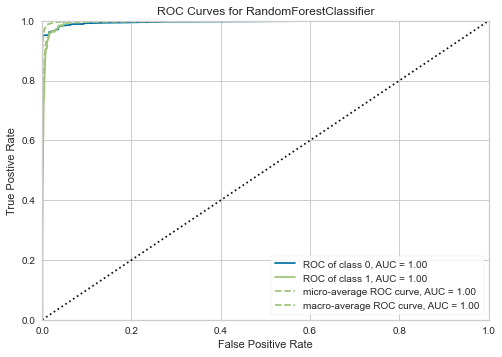

In [21]:
plot_model(tuned_xgboost, plot = 'auc')

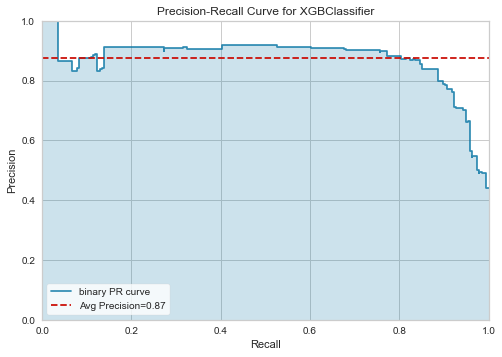

In [56]:
plot_model(tuned_xgboost, plot = 'pr')

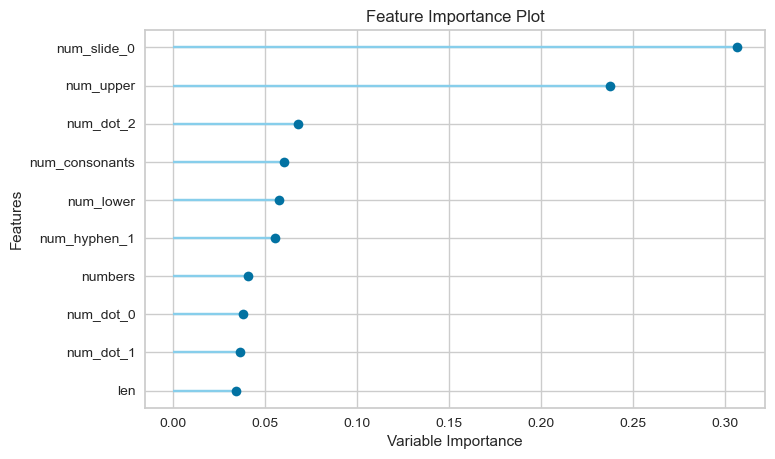

In [57]:
plot_model(tuned_xgboost, plot='feature')

In [59]:
df_model = predict_model(tuned_xgboost)
df_model

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9871,0.9948,0.8866,0.839,0.8622,0.8554,0.8558


,numbers,num_upper,len,num_lower,num_vowels,num_consonants,num_spaces_0,num_slide_0,num_slide_1,num_slide_2,...,num_hyphen_2,num_hyphen_3,num_dot_0,num_dot_1,num_dot_2,num_dot_3,POS_PROPN_0,acronym,Label,Score
0,0.000000,0.000000,4.0,1.000000,0.500000,0.500000,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.0001
1,0.000000,0.000000,7.0,1.000000,0.428571,0.571429,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.0000
2,0.000000,0.000000,10.0,1.000000,0.400000,0.600000,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.0000
3,0.000000,0.000000,10.0,1.000000,0.600000,0.400000,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.0000
4,0.000000,0.000000,10.0,1.000000,0.400000,0.600000,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4266,0.000000,0.000000,16.0,1.000000,0.437500,0.562500,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.0000
4267,0.000000,0.000000,11.0,1.000000,0.363636,0.636364,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.0000
4268,0.000000,0.000000,10.0,1.000000,0.400000,0.600000,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.0000
4269,0.555556,0.000000,9.0,0.222222,0.000000,0.222222,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,0.0000


In [66]:
#Split target and corpus data
Y = train_tokens.acronym
X = train_tokens.drop(['acronym'], axis=1)

In [67]:
#Split in train and test 
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.33, random_state=1234)

In [71]:
model = RandomForestClassifier(random_state=123)
model.fit(Xtrain, Ytrain)
predictions = model.predict(Xtest)
# plt.scatter(Ytest, predictions, alpha = 0.4)

### Interpretability

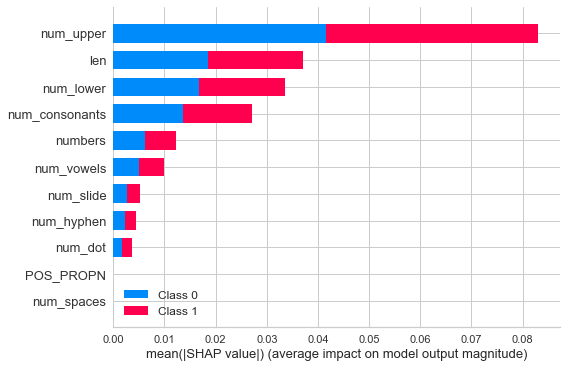

In [73]:
explainer = shap.TreeExplainer(model, predict_disable_shape_check= True)
shap_values = explainer.shap_values(Xtrain)
shap.summary_plot(shap_values, features=Xtrain, feature_names=Xtrain.columns)

#### Other preprocessing

In [34]:
#Remove stop words
train_raw['texto_clean'] = train_raw['tokens'].map(lambda x: ' '.join([w for w in x if w not in swords]))

In [35]:
#Remove white spaces
train_raw['texto_clean'] = train_raw['texto_clean'].map(lambda x: x.strip())

In [36]:
#Split text in sentences
train_raw['texto_sentences'] = train_raw['texto_clean'].map(lambda x: re.split(r"\.|\?|\!", x))

In [37]:
#POS tagging
train_raw['texto_POS'] = train_raw['texto_clean'].map(lambda x: st.tag(nltk.word_tokenize(x)))

In [38]:
train_raw.head()

,doc_id,texto,tokens,texto_clean,texto_sentences,texto_POS
0,S0004-06142005000900013-1,Se trata de una mujer de 29 años sometida a un...,"[Se, trata, mujer, 29, años, sometida, estudio...",Se trata mujer 29 años sometida estudio ecográ...,[Se trata mujer 29 años sometida estudio ecogr...,"[(Se, PRON), (trata, VERB), (mujer, NOUN), (29..."
1,S0004-06142005000900015-1,"Varón de 36 años, sin antecedentes de interés,...","[Varón, 36, años, antecedentes, interés, estud...",Varón 36 años antecedentes interés estudiado c...,[Varón 36 años antecedentes interés estudiado ...,"[(Varón, PROPN), (36, NUM), (años, NOUN), (ant..."
2,S0004-06142005000900016-1,Mujer de 29 años con antecedentes de ulcus duo...,"[Mujer, 29, años, antecedentes, ulcus, duodena...",Mujer 29 años antecedentes ulcus duodenal estr...,[Mujer 29 años antecedentes ulcus duodenal est...,"[(Mujer, NOUN), (29, NUM), (años, NOUN), (ante..."
3,S0004-06142005001000011-1,Varón de 58 años de edad en el momento del tra...,"[Varón, 58, años, edad, momento, trasplante, 5...",Varón 58 años edad momento trasplante 5 octubr...,[Varón 58 años edad momento trasplante 5 octub...,"[(Varón, PROPN), (58, NUM), (años, NOUN), (eda..."
4,S0004-06142005001000011-3,Mujer de 42 años en el momento de someterse a ...,"[Mujer, 42, años, momento, someterse, trasplan...",Mujer 42 años momento someterse trasplante hep...,[Mujer 42 años momento someterse trasplante he...,"[(Mujer, NOUN), (42, NUM), (años, NOUN), (mome..."


### Detect acronym with patterns and heuristic search

In [39]:
rules = [lambda concept: sum(x.isdigit() for x in concept) <= 1, # could have one digit
        lambda concept: any(x.isalpha() for x in concept),  # must have at least one letter
        lambda concept: sum(x.isupper() for x in concept) >= 2,  # must have at least one uppercase
        lambda concept: sum(x.isspace() for x in concept) <= 1,  # could have just one white space
        lambda concept: (len(concept) >= 2 and len(concept) <= 10), # must be more than 2 characters and at least 10 characters
#         lambda concept: concept.startswith('(')
        ]

In [40]:
train_raw['acronym'] = train_raw['texto_POS'].map(lambda x: [a[0] for a in x if (all(rule(a[0]) for rule in rules) and a[1] == 'PROPN')])

In [41]:
train_raw.head()

,doc_id,texto,tokens,texto_clean,texto_sentences,texto_POS,acronym
0,S0004-06142005000900013-1,Se trata de una mujer de 29 años sometida a un...,"[Se, trata, mujer, 29, años, sometida, estudio...",Se trata mujer 29 años sometida estudio ecográ...,[Se trata mujer 29 años sometida estudio ecogr...,"[(Se, PRON), (trata, VERB), (mujer, NOUN), (29...",[DAKO]
1,S0004-06142005000900015-1,"Varón de 36 años, sin antecedentes de interés,...","[Varón, 36, años, antecedentes, interés, estud...",Varón 36 años antecedentes interés estudiado c...,[Varón 36 años antecedentes interés estudiado ...,"[(Varón, PROPN), (36, NUM), (años, NOUN), (ant...","[CT, MESNA]"
2,S0004-06142005000900016-1,Mujer de 29 años con antecedentes de ulcus duo...,"[Mujer, 29, años, antecedentes, ulcus, duodena...",Mujer 29 años antecedentes ulcus duodenal estr...,[Mujer 29 años antecedentes ulcus duodenal est...,"[(Mujer, NOUN), (29, NUM), (años, NOUN), (ante...",[UIV]
3,S0004-06142005001000011-1,Varón de 58 años de edad en el momento del tra...,"[Varón, 58, años, edad, momento, trasplante, 5...",Varón 58 años edad momento trasplante 5 octubr...,[Varón 58 años edad momento trasplante 5 octub...,"[(Varón, PROPN), (58, NUM), (años, NOUN), (eda...","[IRC, IgA, II, EEII, EEII, ROT, RCP, RMN, LCR,..."
4,S0004-06142005001000011-3,Mujer de 42 años en el momento de someterse a ...,"[Mujer, 42, años, momento, someterse, trasplan...",Mujer 42 años momento someterse trasplante hep...,[Mujer 42 años momento someterse trasplante he...,"[(Mujer, NOUN), (42, NUM), (años, NOUN), (mome...","[HDA, II, EEII, EID, EID, ROT, RCP, RMN, PEES,..."


In [42]:
# tokens = train_raw.iloc[40]['texto_POS']
# for token in tokens:
#     if all(rule(token[0]) for rule in rules) and token[1] == 'PROPN':
#         print(token)

In [43]:
# def acron_detect(concept):
#     if ((len(concept) >= 2 and len(concept) <= 10) and sum(x.isupper() for x in concept) >= 1 and any(x.isalpha() for x in concept) and sum(x.isdigit() for x in concept) <= 1) and \
#     (sum(c.isspace() for c in concept) <= 1):
#         print(concept, "is an acronym")

In [44]:
# tokens = train_raw.iloc[50]['texto_POS']
# for x in tokens:
#     acron_detect(x)

In [45]:
# s = 'qiwuei&oqw&'
# any(re.findall(r'\&', s))

### Check

In [46]:
print(train_raw.iloc[15]['doc_id'])
train_raw.iloc[15]['acronym']

S0004-06142006000900015-1


['TAC', 'pT3aNoMo', 'II', 'IV', 'TAC', 'TAC']

In [47]:
train_abbr[train_abbr['doc_id'] == 'S0004-06142006000900015-1']

,doc_id,StartOffset,EndOffset,Abbreviation,Definition,Definition_lemmatized
2073,S0004-06142006000900015-1,963,966,TAC,tomografía axial computarizada,tomografía axial computarizado
2074,S0004-06142006000900015-1,179,182,TAC,tomografía axial computarizada,tomografía axial computarizado
2075,S0004-06142006000900015-1,276,278,cm,centímetro,centímetro
2076,S0004-06142006000900015-1,1890,1893,TAC,tomografía axial computarizada,tomografía axial computarizado


In [48]:
pd.set_option('display.max_rows', None)
train_abbr[['Abbreviation']].drop_duplicates().sort_values(by = 'Abbreviation')

,Abbreviation
1214,5-FU
499,67Ga
2544,99-MDP
501,99Tc
137,A
1581,A-P
1532,A1AT
584,AA
950,AAS
1028,AAT
